In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sub = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
df = pd.concat([df_train,df_test], axis=0, sort=False)
df.shape

(2919, 81)

In [5]:
df = df.set_index('Id')

In [6]:
train_id = df_train.shape[0]
SEED = 66

# **Missing values**

In [7]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(i + ' : ' + str(round(df[i].isna().sum() / df.shape[0] * 100, 2)) + ' %')

MSZoning : 0.14 %
LotFrontage : 16.65 %
Alley : 93.22 %
Utilities : 0.07 %
Exterior1st : 0.03 %
Exterior2nd : 0.03 %
MasVnrType : 0.82 %
MasVnrArea : 0.79 %
BsmtQual : 2.77 %
BsmtCond : 2.81 %
BsmtExposure : 2.81 %
BsmtFinType1 : 2.71 %
BsmtFinSF1 : 0.03 %
BsmtFinType2 : 2.74 %
BsmtFinSF2 : 0.03 %
BsmtUnfSF : 0.03 %
TotalBsmtSF : 0.03 %
Electrical : 0.03 %
BsmtFullBath : 0.07 %
BsmtHalfBath : 0.07 %
KitchenQual : 0.03 %
Functional : 0.07 %
FireplaceQu : 48.65 %
GarageType : 5.38 %
GarageYrBlt : 5.45 %
GarageFinish : 5.45 %
GarageCars : 0.03 %
GarageArea : 0.03 %
GarageQual : 5.45 %
GarageCond : 5.45 %
PoolQC : 99.66 %
Fence : 80.44 %
MiscFeature : 96.4 %
SaleType : 0.03 %
SalePrice : 49.98 %


Several imputation strategies here depending on the data documentation

In [8]:
to_fill_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Exterior2nd']
to_fill_0 = ['LotFrontage', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageCars']
to_fill_freq = ['GarageYrBlt', 'Electrical', 'MSZoning', 'Utilities', 'KitchenQual', 'Functional', 'Exterior1st', 'SaleType']

In [9]:
for i in to_fill_none:
    df[i].fillna('None', inplace=True)

In [10]:
for i in to_fill_0:
    df[i].fillna(0, inplace=True)

To avoid data leakage we'll take the most frequent values on the train set

In [11]:
for i in to_fill_freq:
    df[i].fillna(df[i][:train_id].mode().item(), inplace=True)

# **Baseline model**

In [12]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# Metrics
from sklearn.metrics import mean_squared_error

Let's define some functions to automate some tasks


In [13]:
# We'll use label encoder by default
def encoder(dataset, encoder=LabelEncoder()):
    var_obj = dataset.select_dtypes(include='object').columns
    dataset_cop = dataset.copy()
    le = encoder
    for i in var_obj:
        dataset_cop[i] = le.fit_transform(dataset_cop[i])
    return dataset_cop

In [14]:
def get_data(dataset):
    
    dataset = encoder(dataset)
    
    df_test = dataset[dataset.index > train_id].copy()
    X = dataset.loc[set(dataset.index) - set(df_test.index)].copy()
    y = X.pop('SalePrice')
    
    return X, y, df_test

In [15]:
def split(X, y, seed=SEED):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    return X_train, X_test, y_train, y_test

In [16]:
def scaler(X_train, X_test, scaler_func, df_test=None):
    scal = scaler_func
    X_train = scal.fit_transform(X_train)
    X_test = scal.transform(X_test)
    if df_test is not None:
        df_test.drop('SalePrice', axis=1, inplace=True)
        df_test = scal.transform(df_test)
    return X_train, X_test, df_test

In [17]:
# we'll use standard scaler by default
def get_score(dataset, estimator, scaler_func=StandardScaler()):
    
    dataset = encoder(dataset)
    
    X, y, _ = get_data(dataset)
    
    X_train, X_test, y_train, y_test = split(X, y)
    
    X_train, X_test, _ = scaler(X_train, X_test, scaler_func)
    
    model = estimator.fit(X_train, y_train)
    pred = model.predict(X_test)
    # we use log to be on the same scale than the leaderboard
    score = mean_squared_error(np.log(y_test), np.log(pred), squared=False)
    return score

In [18]:
models = [RandomForestRegressor(), LGBMRegressor(), XGBRegressor(), CatBoostRegressor(verbose=0), ElasticNet(alpha=0.1, l1_ratio=0, random_state=6)]
for i in models:
    print(str(i) + ' : ' + str(get_score(df, i)))

RandomForestRegressor() : 0.1494334162373545
LGBMRegressor() : 0.14083065067072237
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) : 0.15020459468393965
<catboost.core.CatBoostRegressor object at 0x7ff718f596d0> : 0.12446103454351305
ElasticNet(alpha=0.1, l1_ratio=0, random_state=6) : 0.16929505578301285


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597816507797.4038, tolerance: 721408818.9985667
  positive)


I'll chose Catboost as estimator

# **Outliers**

Let's take a look at the distribution of numerical variables

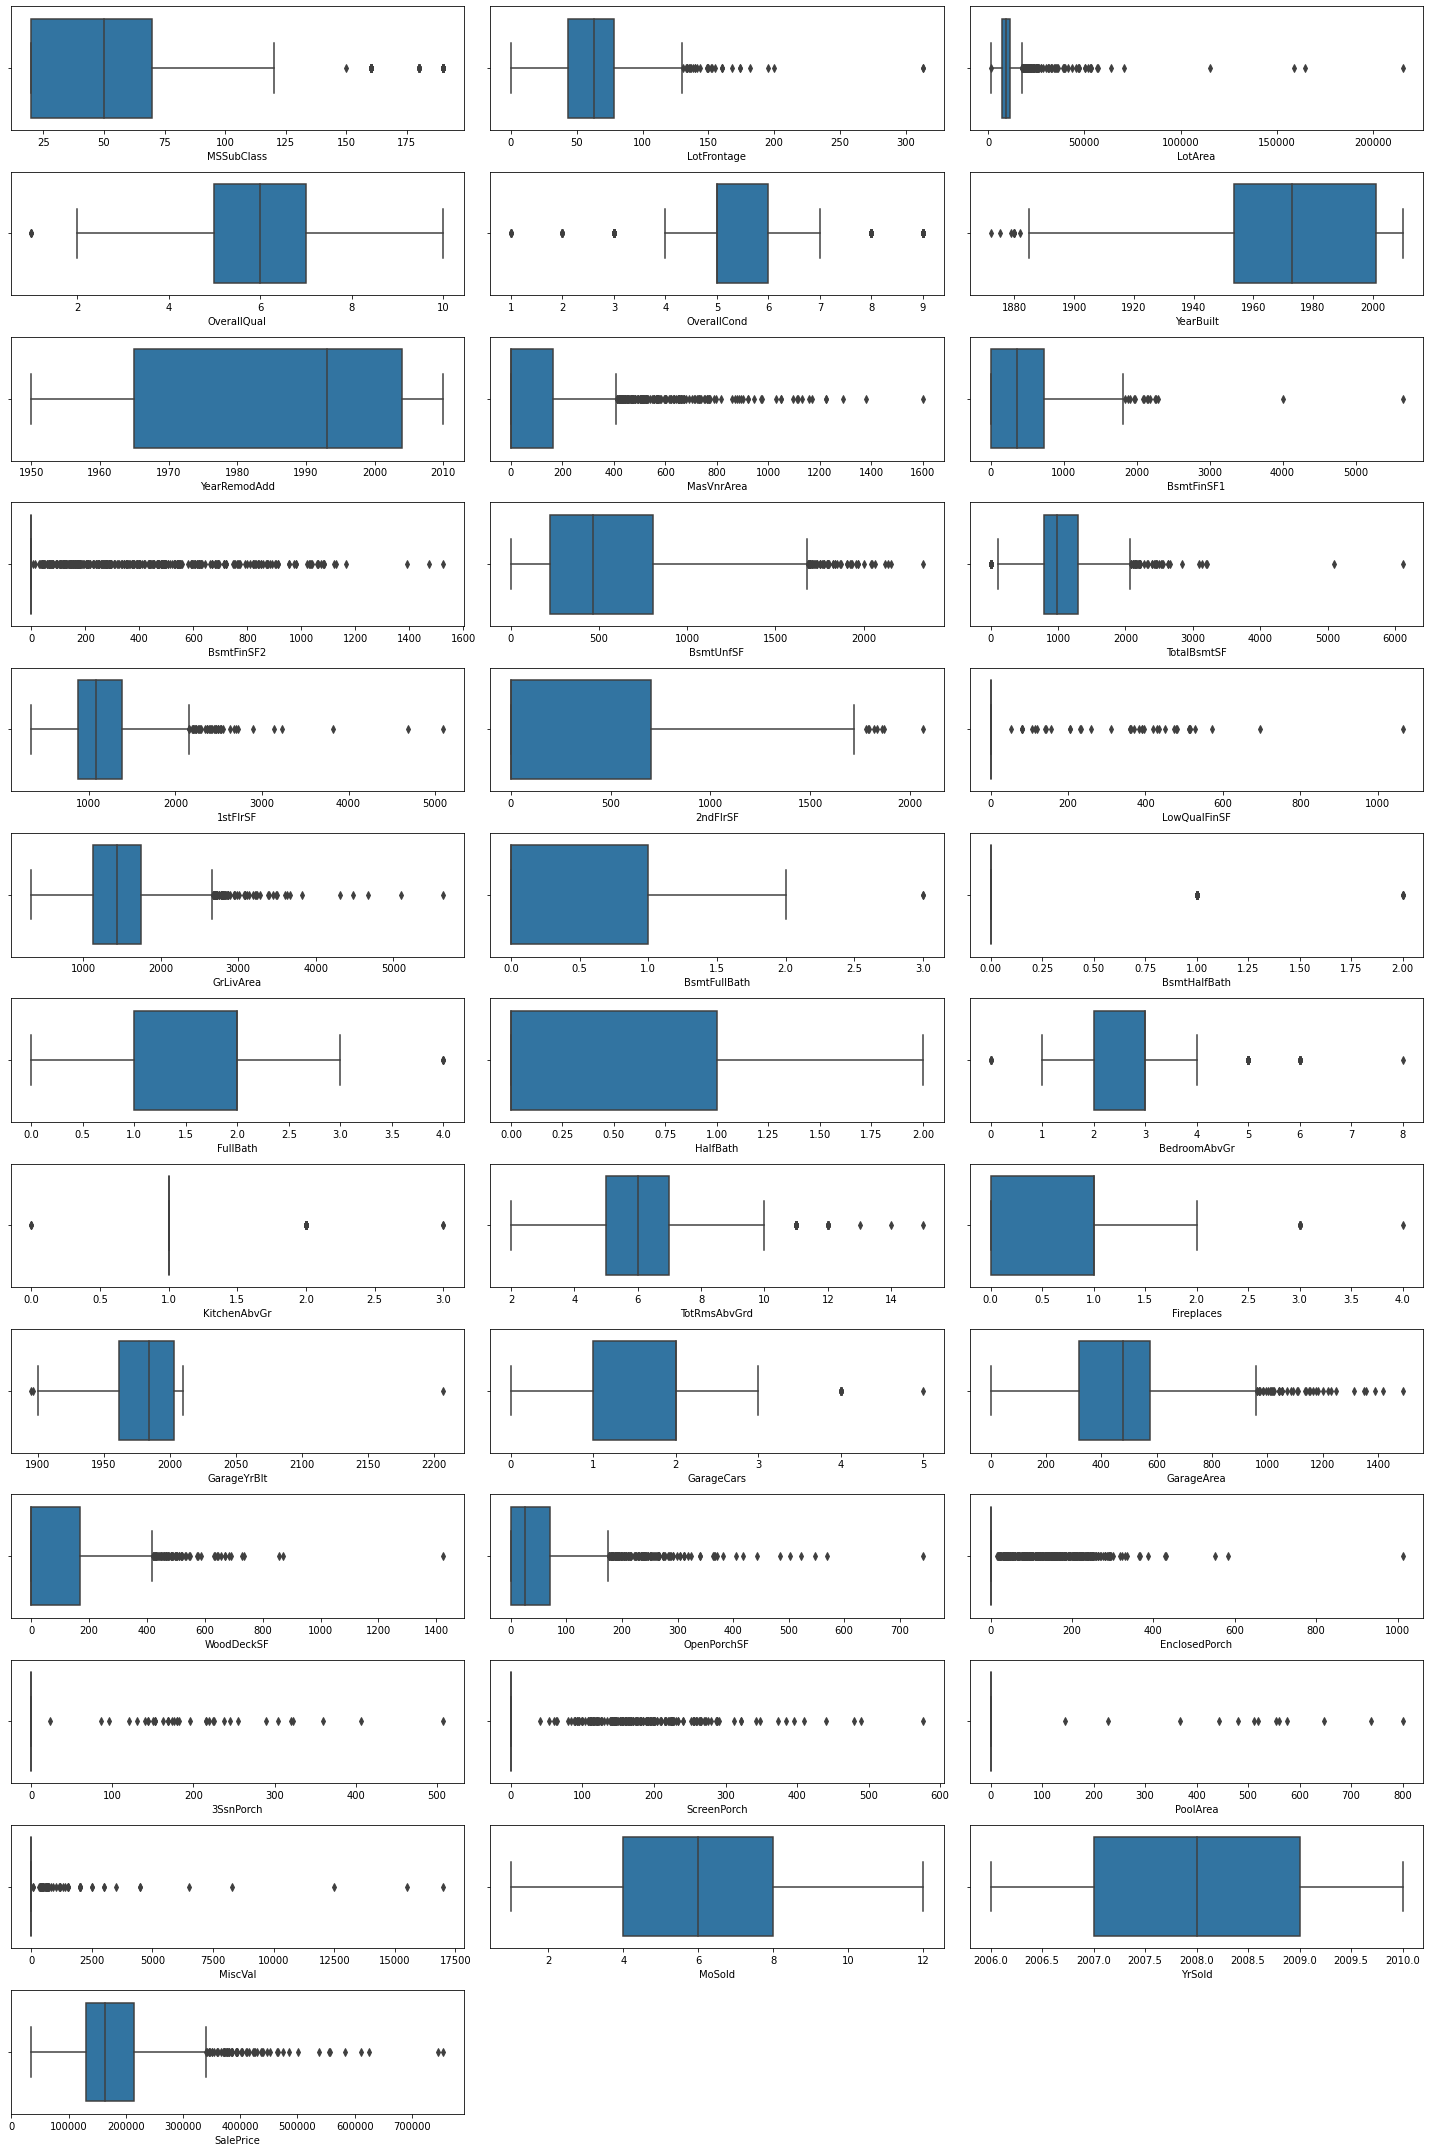

In [19]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns 

var_num = df.select_dtypes(include=['float', 'int']).columns
c = 1 
nrows = round(len(var_num) / 3) + 1
fig = plt.figure(figsize=(20,30))
for i in var_num:
    plt.subplot(nrows, 3, c)
    sns.boxplot(df[i])
    c += 1 
plt.tight_layout()
plt.show()

Some cleans due to visual inspection 

In [20]:
df[df['GarageYrBlt'] > 2100]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2593,20,RL,68.0,8298,Pave,None,IR1,HLS,AllPub,Inside,...,0,None,None,None,0,9,2007,New,Partial,NaN


In [21]:
df.loc[2593, 'GarageYrBlt'] = df.loc[2593, 'YearBuilt']

From the distribution of each features i selected those where dropping outliers could benefit the model

In [22]:
contain_outliers = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

I define a function to test different rate where the observations above the rate will be deleted

We'll drop outliers only from the train set

In [23]:
def outliers(rate):
    
    train = df[:train_id]
    limit = {}
    
    for i in contain_outliers:
        limit[i] = train[i].quantile(rate)
        
    for i, j in limit.items():
        train = train[train[i] < j]
        
    df_all = pd.concat([train, df[train_id:]])
    
    return str(rate) + ' : ' + str(get_score(df_all, CatBoostRegressor(verbose=0))) + ' : ' + str(df[:train_id].shape[0] - train.shape[0])

In [24]:
rate = [0.994, 0.995, 0.996, 0.997, 0.998, 0.999]

In [25]:
for i in rate:
    print(outliers(i))

0.994 : 0.10668243874611143 : 115
0.995 : 0.1048420320457453 : 106
0.996 : 0.10786803974332551 : 88
0.997 : 0.12239802930350717 : 79
0.998 : 0.11951868492331702 : 60
0.999 : 0.09787184479507154 : 49


The rate 0.999 seems to lead at the best result

We lost about fifty observations 

In [26]:
train = df[:train_id]
limit = {}
for i in contain_outliers:
    limit[i] = train[i].quantile(0.999)

In [27]:
for i, j in limit.items():
    train = train[train[i] < j]

In [28]:
df = pd.concat([train, df[train_id:]])

# **Feature enginneering**

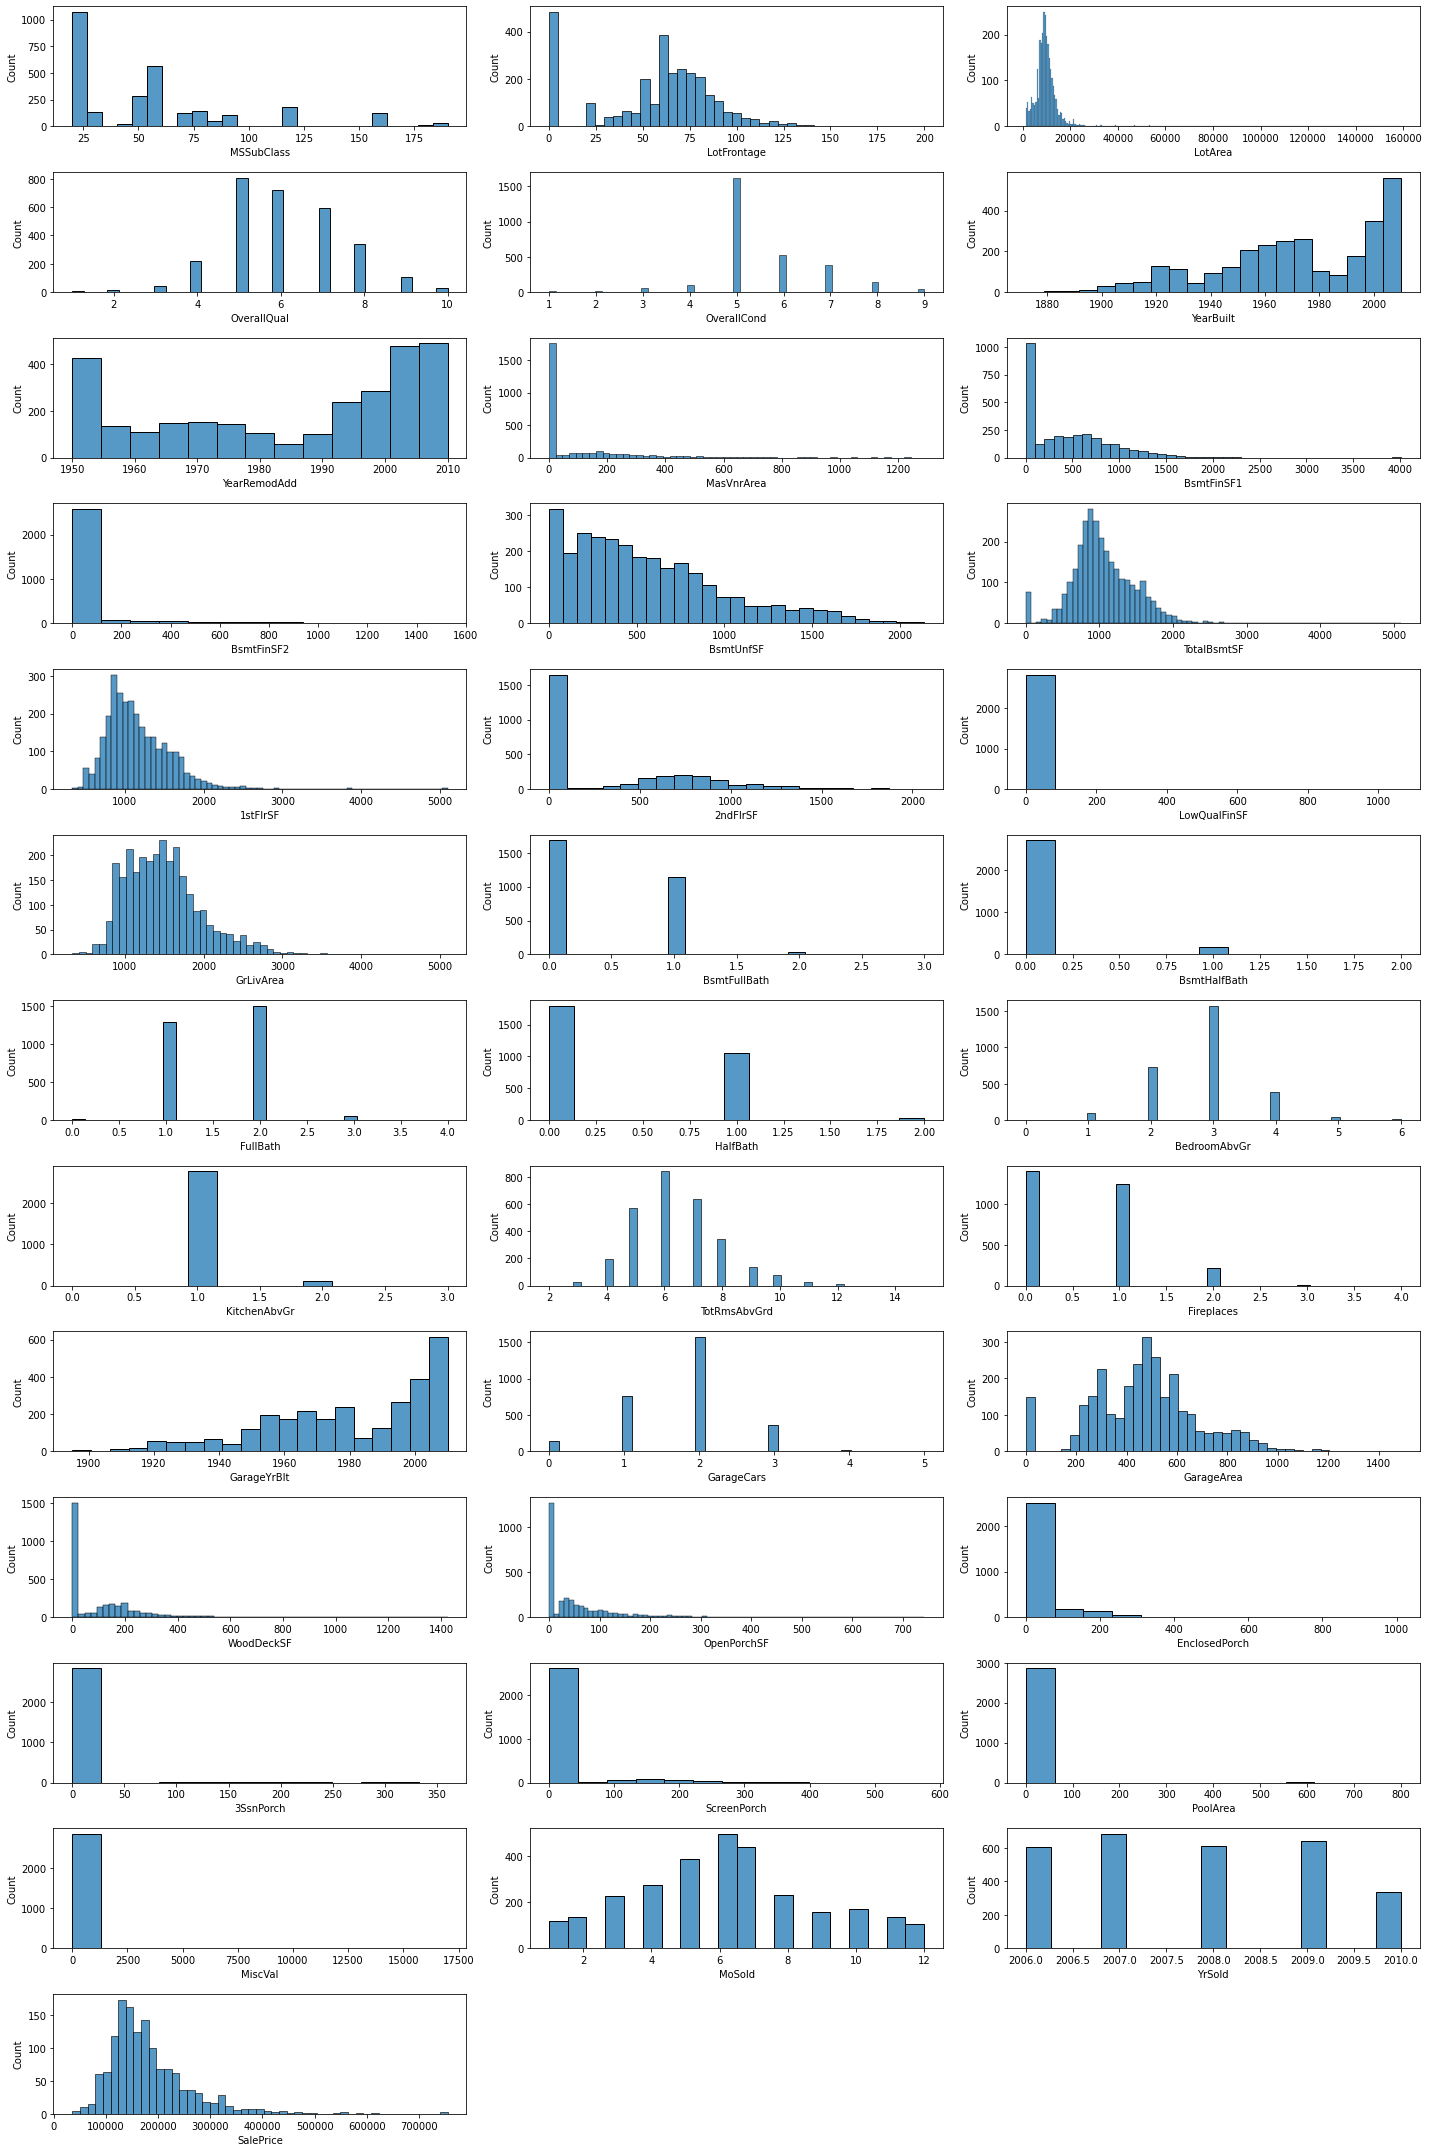

In [29]:
c = 1 
nrows = round(len(var_num) / 3) + 1
fig = plt.figure(figsize=(20,30))
for i in var_num:
    plt.subplot(nrows, 3, c)
    sns.histplot(df[i])
    c += 1 
plt.tight_layout()
plt.show()

Two possible transformations here depending on the distribution of the features : 
* Bin the values
* Transform the feature in a binary feature (for example, has or hasn't a pool)

In [30]:
to_bin = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea']
to_binarize = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [31]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

In [32]:
bins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

In [33]:
df_copy = df.copy()
df_copy[to_bin] = bins.fit_transform(df_copy[to_bin])

In [34]:
get_score(df_copy, CatBoostRegressor(verbose=0))

0.10318923372707355

Using the bins transformation on these features leads to a worse result

Let see the impact on the performance of each transformed feature

In [35]:
scoring = get_score(df, CatBoostRegressor(verbose=0))
better_feat = []
for i in to_bin:
    df_copy = df.copy()
    df_copy[i] = bins.fit_transform(np.array(df_copy[i]).reshape(-1, 1))
    scoring_new = get_score(df_copy, CatBoostRegressor(verbose=0))
    if scoring_new < scoring:
        better_feat.append(i)

In [36]:
better_feat

['LotArea', 'YearRemodAdd', 'BsmtUnfSF', 'GarageYrBlt']

In [37]:
to_bin = ['LotArea', 'YearRemodAdd', 'BsmtUnfSF', 'GarageYrBlt']
df[to_bin] = bins.fit_transform(df[to_bin])
get_score(df, CatBoostRegressor(verbose=0))

0.09842335484705651

Same process for the features to binarize

In [38]:
binarizer = Binarizer(threshold=0.5)

In [39]:
df_copy = df.copy()
df_copy[to_binarize] = binarizer.fit_transform(df_copy[to_binarize])

In [40]:
get_score(df_copy, CatBoostRegressor(verbose=0))

0.09879693084931516

In [41]:
scoring = get_score(df, CatBoostRegressor(verbose=0))
better_feat = []
for i in to_binarize:
    df_copy = df.copy()
    df_copy[i] = binarizer.fit_transform(np.array(df_copy[i]).reshape(-1, 1))
    scoring_new = get_score(df_copy, CatBoostRegressor(verbose=0))
    if scoring_new < scoring:
        better_feat.append(i)

In [42]:
better_feat

['PoolArea']

In [43]:
to_binarize = ['PoolArea']
df[to_binarize] = binarizer.fit_transform(df[to_binarize])
get_score(df, CatBoostRegressor(verbose=0), StandardScaler())

0.09761638367830494

# **Hyper parameter optimisation**

I'll use Optuna rather than grid search

In [44]:
import optuna
from optuna.samplers import TPESampler

In [45]:
def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),    
        'random_state': trial.suggest_categorical('random_state', [6, 9, 12, 15])
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param)
    reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)        
    return score           

In [46]:
X, y, df_test = get_data(df)
X_train, X_test, y_train, y_test = split(X, y)                                                                      

In [47]:
""" 

This will take a lot of time to run

study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=10000, timeout=3600) # Run for 60 minutes     
print("Number of completed trials: {}".format(len(study.trials)))   
print("Best trial:")
trial = study.best_trial      
     
print("\tBest Score: {}".format(trial.value))                                                                 
print("\tBest Params: ")           
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))     
    
"""

' \n\nThis will take a lot of time to run\n\nstudy = optuna.create_study(sampler=TPESampler(), direction="minimize")\nstudy.optimize(objective, n_trials=10000, timeout=3600) # Run for 60 minutes     \nprint("Number of completed trials: {}".format(len(study.trials)))   \nprint("Best trial:")\ntrial = study.best_trial      \n     \nprint("\tBest Score: {}".format(trial.value))                                                                 \nprint("\tBest Params: ")           \nfor key, value in trial.params.items():\n    print("    {}: {}".format(key, value))     \n    \n'

# **Submission**

In [48]:
def get_sub(dataset, model, scaler_func):
    
    X, y, df_test = get_data(dataset)
    
    X_train, X_test, y_train, y_test = split(X, y)
    
    X_train, X_test, df_test = scaler(X_train, X_test, scaler_func, df_test)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(df_test)
    sub['SalePrice'] = pred
    
    return sub

In [49]:
sub = get_sub(df, 
    CatBoostRegressor(loss_function='RMSE',
                      learning_rate=0.07632340853297458,
                      l2_leaf_reg=0.015170633257026214,
                      colsample_bylevel=0.0956372937135792,
                      depth=4,
                      boosting_type='Plain',
                      bootstrap_type='MVS',
                      min_data_in_leaf=8,
                      one_hot_max_size=12,
                      verbose=0,
                      random_state=12), 
    RobustScaler())
sub.to_csv('submission.csv', index=False)

Thanks to : 
https://www.kaggle.com/saurabhshahane/catboost-hyperparameter-tuning-with-optuna
